# New Section

In [1]:
!pip install skforecast -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.0/815.0 kB 14.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.5/242.5 kB 10.1 MB/s eta 0:00:00


# LIBRARIES AND SETUP

In [ ]:


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('seaborn-v0_8-whitegrid')

# skforecast imports
from skforecast.sarimax import Sarimax
from skforecast.recursive import ForecasterSarimax
from skforecast.model_selection import TimeSeriesFold
from skforecast.model_selection import backtesting_sarimax
from skforecast.model_selection import grid_search_sarimax

# Statistical analysis
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose

print("Libraries loaded successfully")

✅ Libraries loaded successfully


# DATA LOADING AND PREPARATION (Targets, Youth Unemployment Rate: 15–24 and 15–30)

In [ ]:


# Load youth unemployment dataset
URL_YOUTH = 'https://storage.dosm.gov.my/labour/lfs_month_youth.parquet'
df_youth = pd.read_parquet(URL_YOUTH)

# Standardize datetime index
df_youth['date'] = pd.to_datetime(df_youth['date'])
df_youth = df_youth.set_index('date')
df_youth = df_youth.asfreq('MS')  # Monthly start

# Show basic info
print(f"Youth dataset shape: {df_youth.shape}")
print(f"Date range: {df_youth.index.min()} to {df_youth.index.max()}")

# Extract youth unemployment rate series for 15–24 and 15–30
unemp_15_24 = df_youth['u_rate_15_24'].copy().asfreq('MS')
unemp_15_30 = df_youth['u_rate_15_30'].copy().asfreq('MS')

# print stat
print("\nPreview (15–24):\n", unemp_15_24.head())
print("\nPreview (15–30):\n", unemp_15_30.head())

print(f"\nUnemployment rate series length: {len(unemp_15_24)} months (15–24)")
print(f"Unemployment rate series length: {len(unemp_15_30)} months (15–30)")



DATA LOADING AND PREPARATION (YOUTH UNEMPLOYMENT: 15–24 AND 15–30)
Youth dataset shape: (111, 4)
Date range: 2016-01-01 00:00:00 to 2025-03-01 00:00:00

Preview (15–24):
 date
2016-01-01    10.7
2016-02-01     9.0
2016-03-01    10.9
2016-04-01    11.5
2016-05-01    11.1
Freq: MS, Name: u_rate_15_24, dtype: float64

Preview (15–30):
 date
2016-01-01    6.9
2016-02-01    5.7
2016-03-01    7.0
2016-04-01    6.9
2016-05-01    6.8
Freq: MS, Name: u_rate_15_30, dtype: float64

Unemployment rate series length: 111 months (15–24)
Unemployment rate series length: 111 months (15–30)


# DATA QUALITY CHECK AND MISSING VALUE HANDLING (for Youth: 15–24 and 15–30)

In [ ]:


def check_and_clean_data(series, name):
    """Check data quality and handle missing values"""
    print(f"Data Quality Check: {name}")


    print(f"Shape: {series.shape}")
    print(f"Missing values: {series.isna().sum()}")
    print(f"Data type: {series.dtype}")
    print(f"Date range: {series.index.min()} to {series.index.max()}")

    if series.isna().sum() > 0:
        print(f"Found {series.isna().sum()} missing values")

        # Check skewness for imputation method
        skewness = series.skew()
        print(f"Skewness: {skewness:.4f}")

        # Use interpolation for time series data
        series_clean = series.interpolate(method='linear', limit_direction='both')

        # Fill any remaining NAs with median
        if series_clean.isna().sum() > 0:
            fill_value = series.median()
            series_clean = series_clean.fillna(fill_value)
            print(f"Filled remaining NAs with median: {fill_value:.4f}")

        print(f"Missing values after cleaning: {series_clean.isna().sum()}")
        return series_clean
    else:
        print("No missing values found")
        return series

# Clean both youth unemployment series
unemp_15_24 = check_and_clean_data(unemp_15_24, "Youth Unemployment Rate (15–24)")
unemp_15_30 = check_and_clean_data(unemp_15_30, "Youth Unemployment Rate (15–30)")

# Verify data integrity
print(f"\nData cleaning completed:")
print(f"15–24 unemployment: {len(unemp_15_24)} observations, {unemp_15_24.isna().sum()} missing")
print(f"15–30 unemployment: {len(unemp_15_30)} observations, {unemp_15_30.isna().sum()} missing")



DATA QUALITY CHECK AND CLEANING (YOUTH 15–24 AND 15–30)

--------------------------------------------------
Data Quality Check: Youth Unemployment Rate (15–24)
--------------------------------------------------
Shape: (111,)
Missing values: 0
Data type: float64
Date range: 2016-01-01 00:00:00 to 2025-03-01 00:00:00
No missing values found

--------------------------------------------------
Data Quality Check: Youth Unemployment Rate (15–30)
--------------------------------------------------
Shape: (111,)
Missing values: 0
Data type: float64
Date range: 2016-01-01 00:00:00 to 2025-03-01 00:00:00
No missing values found

✅ Data cleaning completed:
15–24 unemployment: 111 observations, 0 missing
15–30 unemployment: 111 observations, 0 missing


# TRAIN-VALIDATION-TEST SPLITS (for Youth: 15–24 and 15–30)


TRAIN-VALIDATION-TEST SPLITS (YOUTH 15–24 AND 15–30)

15–24:
Train period: 2016-01-01 00:00:00 to 2021-12-01 00:00:00 (n=72)
Validation period: 2022-02-01 00:00:00 to 2023-12-01 00:00:00 (n=23)
Test period: 2024-02-01 00:00:00 to 2025-03-01 00:00:00 (n=14)

15–30:
Train period: 2016-01-01 00:00:00 to 2021-12-01 00:00:00 (n=72)
Validation period: 2022-02-01 00:00:00 to 2023-12-01 00:00:00 (n=23)
Test period: 2024-02-01 00:00:00 to 2025-03-01 00:00:00 (n=14)


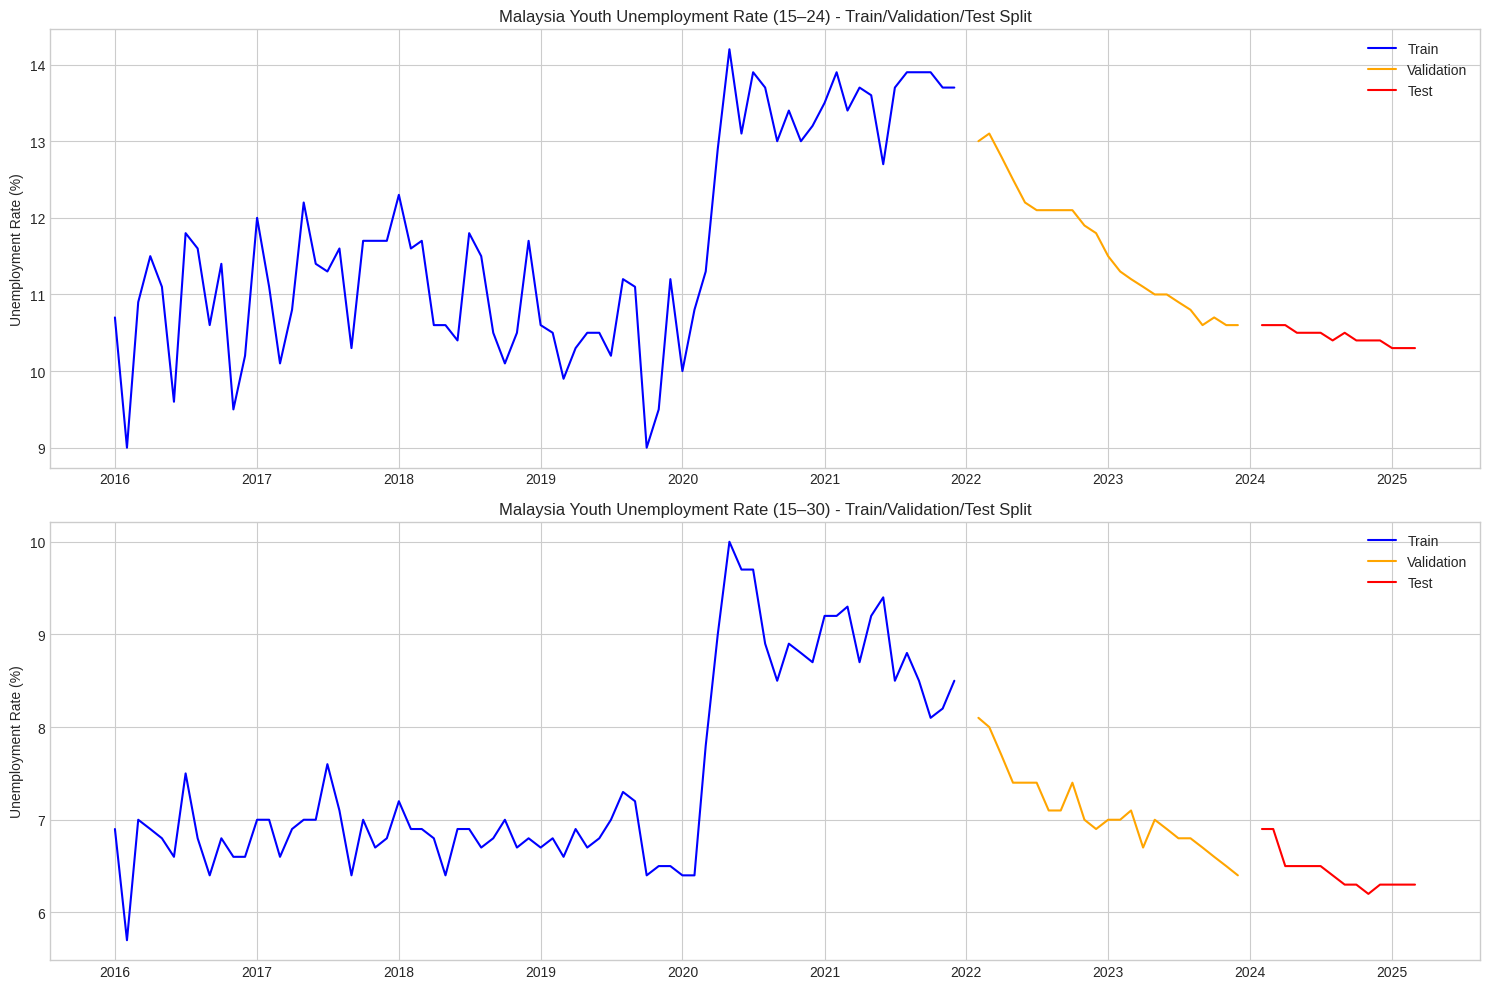

In [ ]:


# Define split dates
end_train = '2021-12-31'  # Train
end_val = '2023-12-31'    # Validation


# 15–24 youth unemployment
train_15_24 = unemp_15_24.loc[:end_train].asfreq('MS')
val_15_24 = unemp_15_24.loc[end_train:end_val].iloc[1:].asfreq('MS')
test_15_24 = unemp_15_24.loc[end_val:].iloc[1:].asfreq('MS')

# 15–30 youth unemployment
train_15_30 = unemp_15_30.loc[:end_train].asfreq('MS')
val_15_30 = unemp_15_30.loc[end_train:end_val].iloc[1:].asfreq('MS')
test_15_30 = unemp_15_30.loc[end_val:].iloc[1:].asfreq('MS')

# Print summary
print(f"\n15–24:")
print(f"Train period: {train_15_24.index.min()} to {train_15_24.index.max()} (n={len(train_15_24)})")
print(f"Validation period: {val_15_24.index.min()} to {val_15_24.index.max()} (n={len(val_15_24)})")
print(f"Test period: {test_15_24.index.min()} to {test_15_24.index.max()} (n={len(test_15_24)})")

print(f"\n15–30:")
print(f"Train period: {train_15_30.index.min()} to {train_15_30.index.max()} (n={len(train_15_30)})")
print(f"Validation period: {val_15_30.index.min()} to {val_15_30.index.max()} (n={len(val_15_30)})")
print(f"Test period: {test_15_30.index.min()} to {test_15_30.index.max()} (n={len(test_15_30)})")

# Plot splits
fig, axes = plt.subplots(2, 1, figsize=(15, 10))

# 15–24 unemployment plot
axes[0].plot(train_15_24.index, train_15_24.values, label='Train', color='blue')
axes[0].plot(val_15_24.index, val_15_24.values, label='Validation', color='orange')
axes[0].plot(test_15_24.index, test_15_24.values, label='Test', color='red')
axes[0].set_title('Malaysia Youth Unemployment Rate (15–24) - Train/Validation/Test Split')
axes[0].set_ylabel('Unemployment Rate (%)')
axes[0].legend()
axes[0].grid(True)

# 15–30 unemployment plot
axes[1].plot(train_15_30.index, train_15_30.values, label='Train', color='blue')
axes[1].plot(val_15_30.index, val_15_30.values, label='Validation', color='orange')
axes[1].plot(test_15_30.index, test_15_30.values, label='Test', color='red')
axes[1].set_title('Malaysia Youth Unemployment Rate (15–30) - Train/Validation/Test Split')
axes[1].set_ylabel('Unemployment Rate (%)')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()


In [6]:
!pip install EMD-signal -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.3/82.3 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.7/119.7 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.5/144.5 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 2.2 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datasets 2.14.4 requires dill<0.3.8,>=0.3.0, but you have dill 0.4.0 which is incompatible.


# CEEMDAN DECOMPOSITION (for LSTM)


CEEMDAN DECOMPOSITION


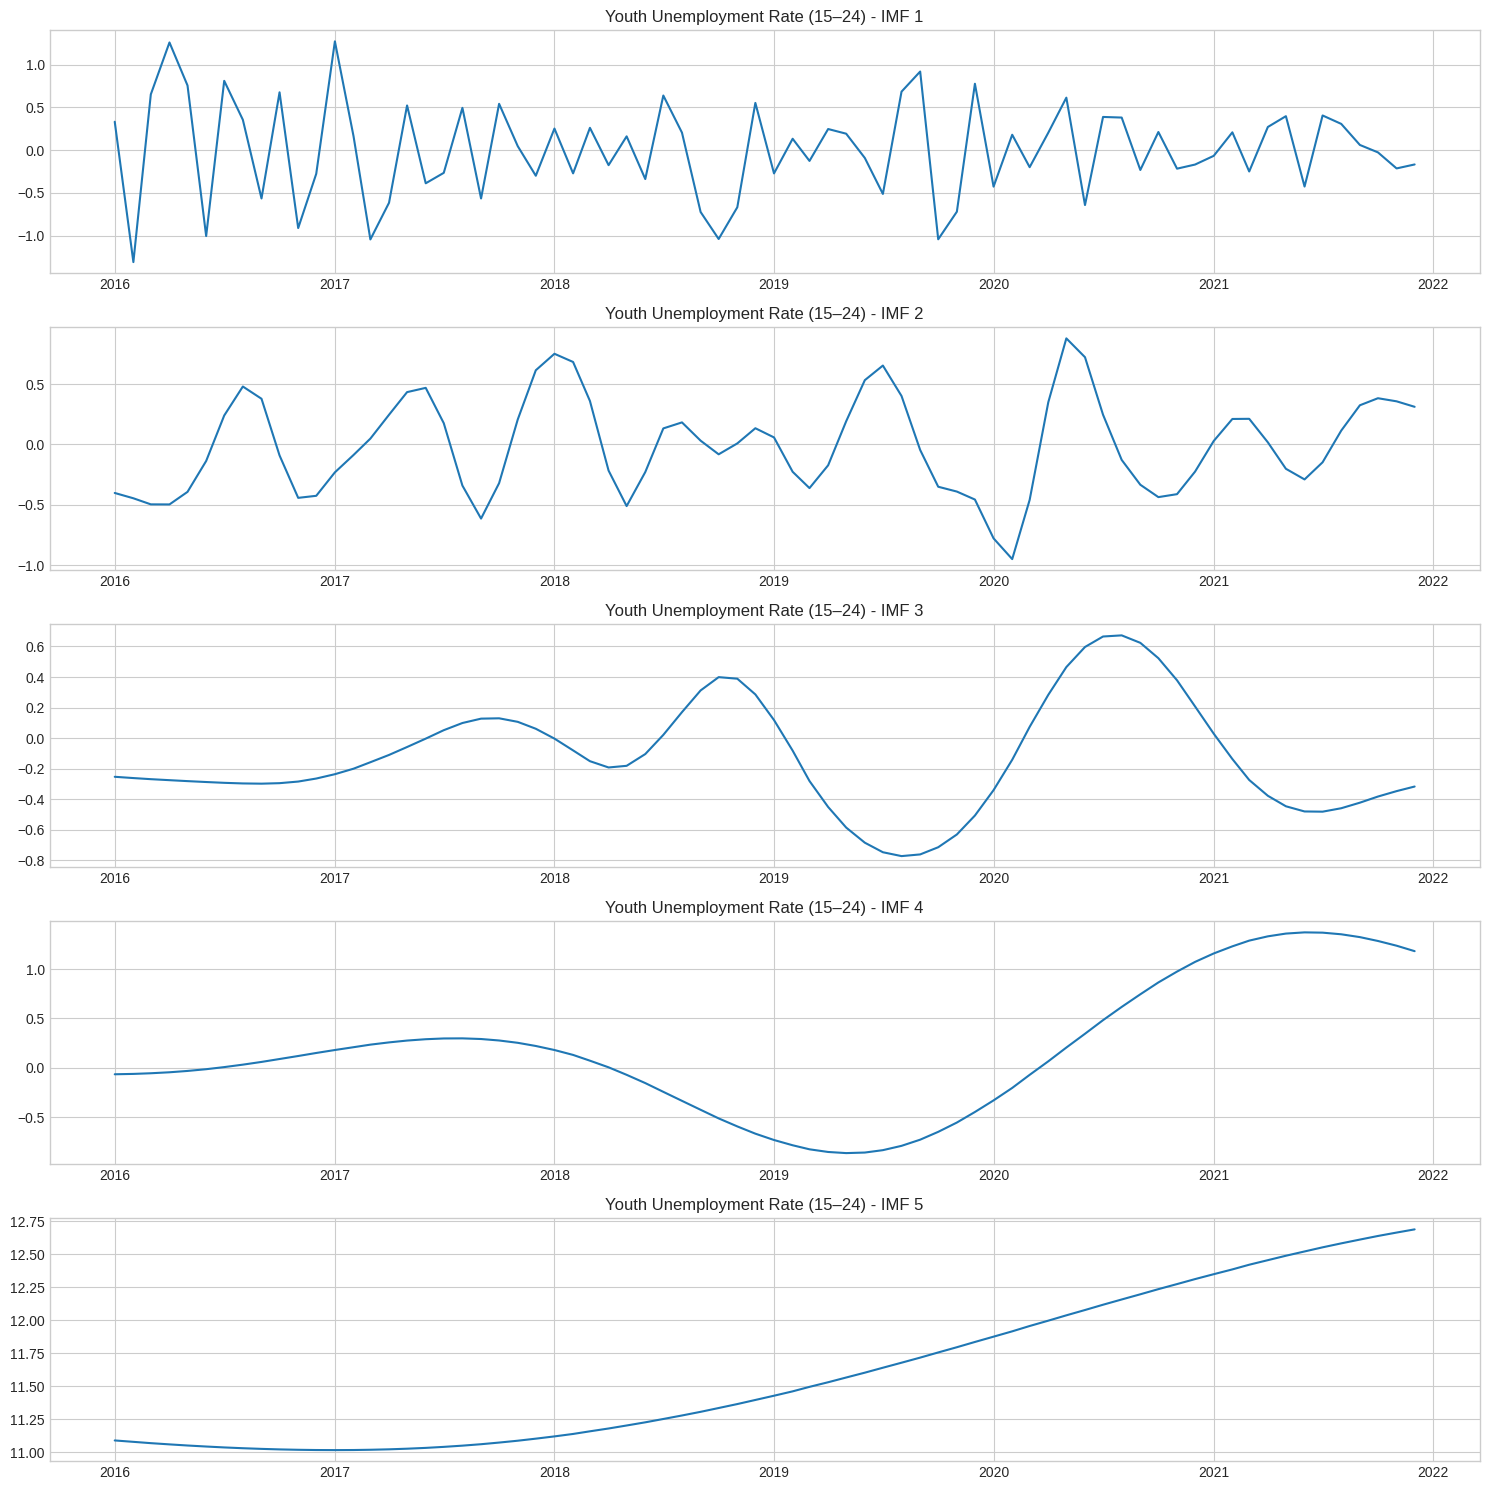

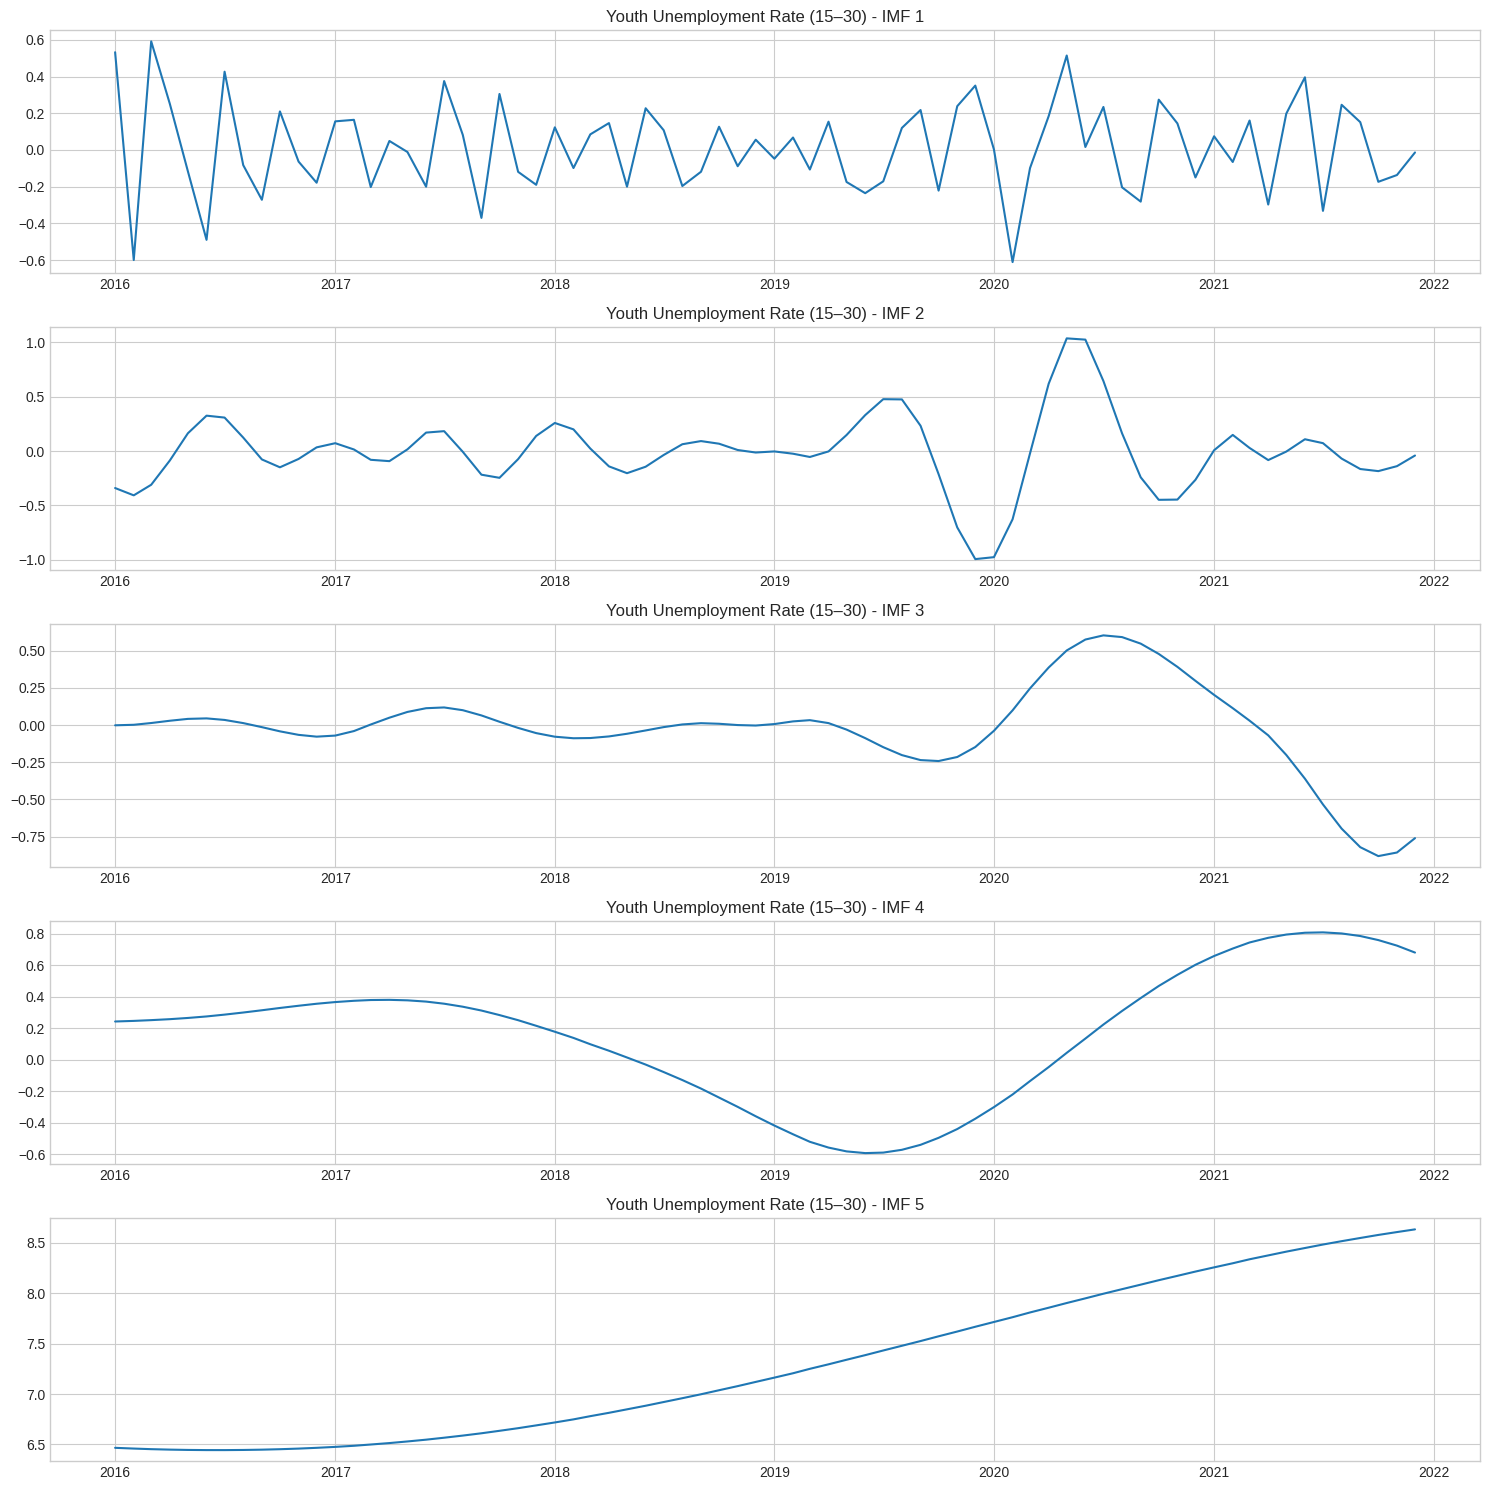

In [ ]:


from PyEMD import CEEMDAN

def plot_ceemdan_decomposition(series, title):
    """Applying CEEMDAN and plot IMFs"""
    ceemdan = CEEMDAN()
    imfs = ceemdan.ceemdan(series.dropna().values)
    n_imfs = len(imfs)

    fig, axes = plt.subplots(n_imfs, 1, figsize=(15, 3 * n_imfs))
    if n_imfs == 1:
        axes = [axes]  # Make it iterable

    for i, imf in enumerate(imfs):
        axes[i].plot(series.index[:len(imf)], imf)
        axes[i].set_title(f'{title} - IMF {i+1}')
        axes[i].grid(True)

    plt.tight_layout()
    plt.show()

    return imfs

# Apply CEEMDAN to both youth unemployment series
imfs_15_24 = plot_ceemdan_decomposition(train_15_24, "Youth Unemployment Rate (15–24)")
imfs_15_30 = plot_ceemdan_decomposition(train_15_30, "Youth Unemployment Rate (15–30)")


# First iteration is pure training and testing, no validation loop or decomposition

✅ Youth dataset: (111, 4)  (range 2016-01-01 → 2025-03-01)


▶️  Training target: u_rate_15_24
   MAE  0.661   RMSE  0.828


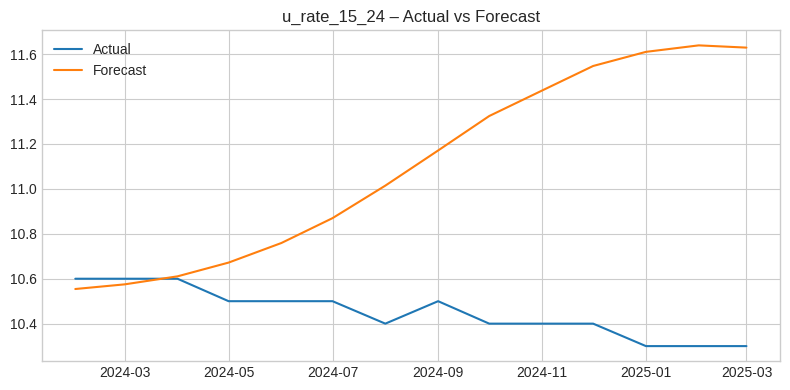



▶️  Training target: u_rate_15_30
   MAE  0.535   RMSE  0.551


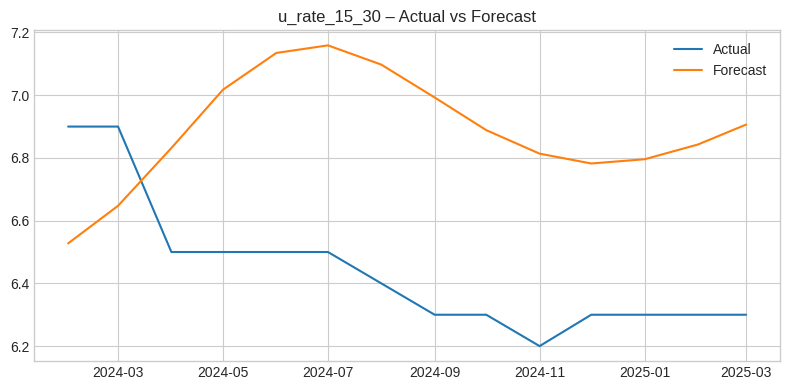


🎉  Iteration 1 complete.  Files saved:
    lstm_i1_u_rate_15_24.h5 scaler_i1_u_rate_15_24.pkl
    lstm_i1_u_rate_15_30.h5 scaler_i1_u_rate_15_30.pkl
   metrics_i1.json


In [ ]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt, json, math, random, os
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import warnings; warnings.filterwarnings("ignore")
plt.style.use("seaborn-v0_8-whitegrid")

SEED = 42
tf.random.set_seed(SEED); np.random.seed(SEED); random.seed(SEED)

# DATA INGESTION
URL_YOUTH = "https://storage.dosm.gov.my/labour/lfs_month_youth.parquet"
df_youth  = pd.read_parquet(URL_YOUTH)

df_youth["date"] = pd.to_datetime(df_youth["date"])
df_youth        = df_youth.set_index("date").asfreq("MS")     # monthly start

unemp_15_24 = df_youth["u_rate_15_24"].copy().asfreq("MS")
unemp_15_30 = df_youth["u_rate_15_30"].copy().asfreq("MS")

print(f" Youth dataset: {df_youth.shape}  (range {df_youth.index.min().date()} → {df_youth.index.max().date()})")

# TRAIN / TEST SPLIT
END_TRAIN  = "2023-12-31"         # inclusive
TEST_HORIZ = 14                   # months forecast

train_15_24 = unemp_15_24.loc[:END_TRAIN]
test_15_24  = unemp_15_24.loc[END_TRAIN:].iloc[1:TEST_HORIZ+1]

train_15_30 = unemp_15_30.loc[:END_TRAIN]
test_15_30  = unemp_15_30.loc[END_TRAIN:].iloc[1:TEST_HORIZ+1]


def make_windows(series, n_lag):
    X, y = [], []
    for i in range(n_lag, len(series)):
        X.append(series[i-n_lag:i])
        y.append(series[i])
    return np.array(X), np.array(y)

# TRAIN + FORECAST LOOP
N_LAG, EPOCHS, BATCH = 12, 300, 8
targets   = {"u_rate_15_24": (train_15_24, test_15_24),
             "u_rate_15_30": (train_15_30, test_15_30)}
metrics   = {}

for name, (train_series, test_series) in targets.items():
    print(f"\n\n Training target: {name}")

    # Normalized the data to [0,1] using MinMaxScaler
    scaler       = MinMaxScaler()
    train_scaled = scaler.fit_transform(train_series.values.reshape(-1,1))

    # Created lagged training windows
    X_train, y_train = make_windows(train_scaled, N_LAG)
    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))

    # Building the LSTM model architecture
    model = Sequential([
        LSTM(32, return_sequences=True, input_shape=(N_LAG,1)),
        Dropout(0.2),
        LSTM(32),
        Dropout(0.2),
        Dense(1)
    ])
    model.compile(optimizer="adam", loss="mse")
    model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH, verbose=0)

    # Recursive Forecasting
    history  = train_scaled[-N_LAG:].flatten().tolist()
    preds_sc = []
    for _ in range(TEST_HORIZ):
        x_in = np.array(history[-N_LAG:]).reshape((1,N_LAG,1))
        yhat = model.predict(x_in, verbose=0)[0,0]
        preds_sc.append(yhat); history.append(yhat)

    preds     = scaler.inverse_transform(np.array(preds_sc).reshape(-1,1)).flatten()
    actual    = test_series.values
    mae  = mean_absolute_error(actual, preds)
    rmse = math.sqrt(mean_squared_error(actual, preds))
    print(f"   MAE  {mae:.3f}   RMSE  {rmse:.3f}")

    # Ploting
    plt.figure(figsize=(8,4))
    plt.plot(test_series.index, actual, label="Actual")
    plt.plot(test_series.index, preds,  label="Forecast")
    plt.title(f"{name} – Actual vs Forecast")
    plt.legend(); plt.tight_layout(); plt.show()

    # Saveing artefacts
    mfile = f"lstm_i1_{name}.h5"
    sfile = f"scaler_i1_{name}.pkl"
    model.save(mfile); pd.to_pickle(scaler, sfile)

    metrics[name] = {"mae": mae, "rmse": rmse,
                     "model_file": mfile, "scaler_file": sfile}

# SUMMARY
with open("metrics_i1.json", "w") as f: json.dump(metrics, f, indent=2)

print("\n Iteration 1 complete.  Files saved:")
for t in targets: print("   ", metrics[t]["model_file"], metrics[t]["scaler_file"])
print("   metrics_i1.json")


# Second iteration uses CEEMDAN decomposition and but no validation loop

✅ Youth dataset shape (111, 4)  |  2016-01-01 → 2025-03-01


▶️  Target: u_rate_15_24
   Decomposed into 5 IMFs + residual


   ➡️  Combined MAE 1.721 | RMSE 2.047


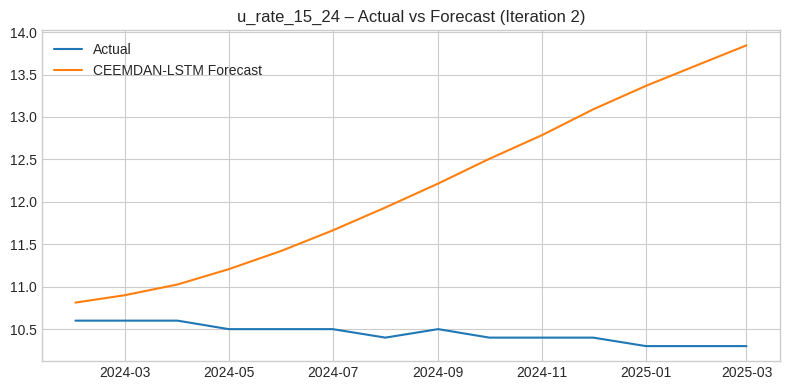



▶️  Target: u_rate_15_30
   Decomposed into 5 IMFs + residual


   ➡️  Combined MAE 2.054 | RMSE 2.785


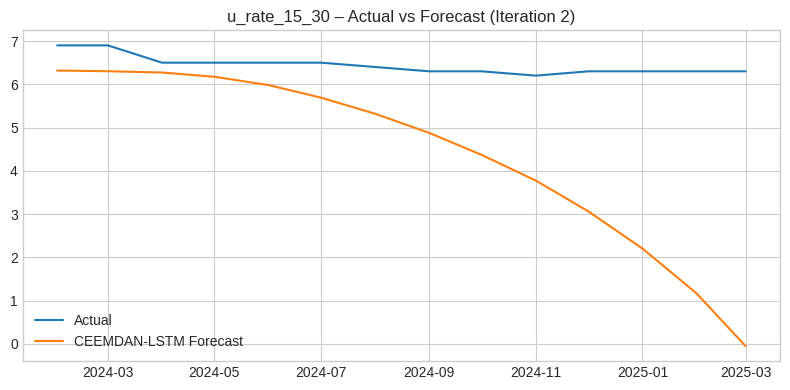


🎉  Iteration 2 complete.  Artefacts saved:
    lstm_i2_u_rate_15_24_imf1.h5 scaler_i2_u_rate_15_24_imf1.pkl
    lstm_i2_u_rate_15_24_imf2.h5 scaler_i2_u_rate_15_24_imf2.pkl
    lstm_i2_u_rate_15_24_imf3.h5 scaler_i2_u_rate_15_24_imf3.pkl
    lstm_i2_u_rate_15_24_imf4.h5 scaler_i2_u_rate_15_24_imf4.pkl
    lstm_i2_u_rate_15_24_imf5.h5 scaler_i2_u_rate_15_24_imf5.pkl
    lstm_i2_u_rate_15_30_imf1.h5 scaler_i2_u_rate_15_30_imf1.pkl
    lstm_i2_u_rate_15_30_imf2.h5 scaler_i2_u_rate_15_30_imf2.pkl
    lstm_i2_u_rate_15_30_imf3.h5 scaler_i2_u_rate_15_30_imf3.pkl
    lstm_i2_u_rate_15_30_imf4.h5 scaler_i2_u_rate_15_30_imf4.pkl
    lstm_i2_u_rate_15_30_imf5.h5 scaler_i2_u_rate_15_30_imf5.pkl
   metrics_i2.json


In [ ]:


import pandas as pd, numpy as np, matplotlib.pyplot as plt, json, math, random, os, warnings
warnings.filterwarnings("ignore")

from PyEMD import CEEMDAN
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

plt.style.use("seaborn-v0_8-whitegrid")
SEED = 42
tf.random.set_seed(SEED); np.random.seed(SEED); random.seed(SEED)

# loading data
URL_YOUTH = "https://storage.dosm.gov.my/labour/lfs_month_youth.parquet"
df = pd.read_parquet(URL_YOUTH)
df["date"] = pd.to_datetime(df["date"])
df        = df.set_index("date").asfreq("MS")        # monthly start

print(f" Youth dataset shape {df.shape}  |  {df.index.min().date()} → {df.index.max().date()}")

# targets to model
TARGETS = ["u_rate_15_24", "u_rate_15_30"]

# splits
END_TRAIN  = "2023-12-31"
HORIZON    = 14          # forecast months
N_LAG      = 12
EPOCHS     = 300
BATCH_SIZE = 8

def sliding_windows(arr, n_lag):
    X, y = [], []
    for i in range(n_lag, len(arr)):
        X.append(arr[i-n_lag:i])
        y.append(arr[i])
    return np.array(X), np.array(y)

# Defining CEEMDAN and model loop
metrics = {}

for target in TARGETS:
    print(f"\n\n Target: {target}")

    full_series = df[target].values
    train_ser   = df[target].loc[:END_TRAIN].values
    test_ser    = df[target].loc[END_TRAIN:].iloc[1:HORIZON+1].values   # 14 months

    # CEEMDAN decomposition
    ceemdan = CEEMDAN()
    imfs    = ceemdan.ceemdan(train_ser, np.arange(len(train_ser)))
    n_imfs  = imfs.shape[0]
    print(f"   Decomposed into {n_imfs} IMFs + residual")

    # holders
    forecast_sum = np.zeros(HORIZON)
    imf_info     = []

    for k in range(n_imfs):
        imf_train = imfs[k].reshape(-1,1)

        # Normalized the data to [0,1] using MinMaxScaler
        scaler = MinMaxScaler()
        train_scaled = scaler.fit_transform(imf_train)

        # Created lagged training windows
        X_train, y_train = sliding_windows(train_scaled, N_LAG)
        X_train = X_train.reshape((X_train.shape[0], N_LAG, 1))

        # Defining model architecture
        model = Sequential([
            LSTM(32, return_sequences=True, input_shape=(N_LAG,1)),
            Dropout(0.2),
            LSTM(32),
            Dropout(0.2),
            Dense(1)
        ])
        model.compile(optimizer="adam", loss="mse")
        model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=0)

        # Recursive forecasting on IMF
        hist   = train_scaled[-N_LAG:].flatten().tolist()
        preds_sc = []
        for _ in range(HORIZON):
            x_in = np.array(hist[-N_LAG:]).reshape((1,N_LAG,1))
            yhat = model.predict(x_in, verbose=0)[0,0]
            preds_sc.append(yhat); hist.append(yhat)
        preds = scaler.inverse_transform(np.array(preds_sc).reshape(-1,1)).flatten()

        forecast_sum += preds

        # saving models
        mfile = f"lstm_i2_{target}_imf{k+1}.h5"
        sfile = f"scaler_i2_{target}_imf{k+1}.pkl"
        model.save(mfile); pd.to_pickle(scaler, sfile)

        imf_info.append({"imf": k+1, "model": mfile, "scaler": sfile})

    # metrics on summed forecast
    mae  = mean_absolute_error(test_ser, forecast_sum)
    rmse = math.sqrt(mean_squared_error(test_ser, forecast_sum))
    print(f"  Combined MAE {mae:.3f} | RMSE {rmse:.3f}")

    # plotting the results
    idx_test = df[target].loc[END_TRAIN:].iloc[1:HORIZON+1].index
    plt.figure(figsize=(8,4))
    plt.plot(idx_test, test_ser,       label="Actual")
    plt.plot(idx_test, forecast_sum,   label="CEEMDAN-LSTM Forecast")
    plt.title(f"{target} – Actual vs Forecast (Iteration 2)")
    plt.legend(); plt.tight_layout(); plt.show()

    # collecting metrics
    metrics[target] = {
        "mae": mae, "rmse": rmse,
        "imfs": n_imfs,
        "components": imf_info
    }

# brief summary
with open("metrics_i2.json", "w") as f: json.dump(metrics, f, indent=2)

print("\n Iteration 2 complete.  Artefacts saved:")
for t in TARGETS:
    for comp in metrics[t]["components"]:
        print("   ", comp["model"], comp["scaler"])
print("   metrics_i2.json")


# For the third iteration we exclude CEEMDAN decomposition and include validation loop

✅ Dataset: (111, 4) | Range: 2016-01-01 → 2025-03-01


▶️  Target: u_rate_15_24
   MAE  0.764   RMSE  0.786


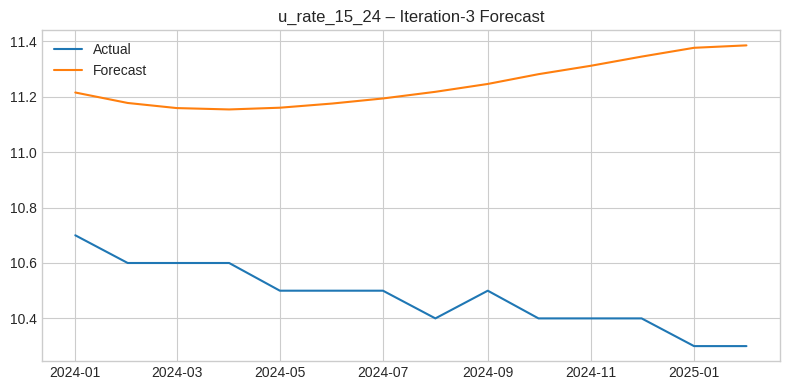



▶️  Target: u_rate_15_30
   MAE  0.267   RMSE  0.285


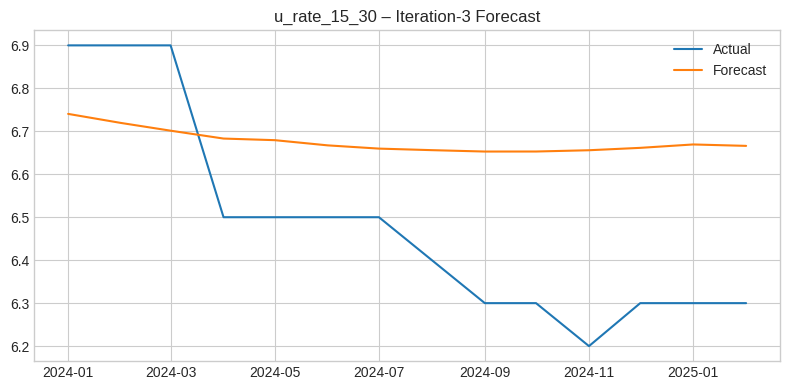


🎉  Iteration-3 complete.  Saved files:
    lstm_i3_u_rate_15_24.h5 scaler_i3_u_rate_15_24.pkl
    lstm_i3_u_rate_15_30.h5 scaler_i3_u_rate_15_30.pkl
   metrics_i3.json


In [ ]:


import pandas as pd, numpy as np, matplotlib.pyplot as plt, json, math, random, os, warnings
warnings.filterwarnings("ignore")

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error


SEED = 42
tf.random.set_seed(SEED);  np.random.seed(SEED);  random.seed(SEED)
plt.style.use("seaborn-v0_8-whitegrid")

# LOAD DATA
URL_PARQUET = "https://storage.dosm.gov.my/labour/lfs_month_youth.parquet"
df = pd.read_parquet(URL_PARQUET)

df["date"] = pd.to_datetime(df["date"])
df = df.set_index("date").asfreq("MS")          # monthly, start-of-month

print(" Dataset:", df.shape,
      "| Range:", df.index.min().date(), "→", df.index.max().date())

TARGETS = ["u_rate_15_24", "u_rate_15_30"]

# making splits and defining key pipeline variables
TRAIN_END   = "2021-12-31"
VAL_START   = "2022-01-01"
VAL_END     = "2023-12-31"
TEST_START  = "2024-01-01"
HORIZON     = 14          # forecast months

N_LAG       = 12          # input window length
EPOCHS      = 400
BATCH_SIZE  = 8
PATIENCE    = 20          # EarlyStopping patience

def make_windows(arr, n_lag):
    X, y = [], []
    for i in range(n_lag, len(arr)):
        X.append(arr[i-n_lag:i])
        y.append(arr[i])
    return np.array(X), np.array(y)

metrics = {}

for col in TARGETS:
    print(f"\n\n  Target: {col}")

    series = df[col]

    train_series = series.loc[:TRAIN_END]
    val_series   = series.loc[VAL_START:VAL_END]
    test_series  = series.loc[TEST_START:].iloc[:HORIZON]

    #  SCALING
    scaler = MinMaxScaler()
    train_scaled = scaler.fit_transform(train_series.values.reshape(-1,1))
    val_scaled   = scaler.transform(val_series.values.reshape(-1,1))

    # CREATEING WINDOWS
    X_train, y_train = make_windows(train_scaled, N_LAG)

    # for validation we need to prepend last N_LAG obs from train
    X_val, y_val = make_windows(
        np.concatenate([train_scaled[-N_LAG:], val_scaled]), N_LAG
    )

    # reshape to (samples, timesteps, features)
    X_train = X_train.reshape((-1, N_LAG, 1))
    X_val   = X_val.reshape((-1, N_LAG, 1))

    # DEFINE MODEL
    model = Sequential([
        LSTM(32, return_sequences=True, input_shape=(N_LAG,1)),
        Dropout(0.2),
        LSTM(32),
        Dropout(0.2),
        Dense(1)
    ])
    model.compile(optimizer="adam", loss="mse")

    es = EarlyStopping(monitor="val_loss",
                       patience=PATIENCE,
                       restore_best_weights=True)

    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        verbose=0,
        callbacks=[es]
    )

    # FORECAST 14 MONTHS RECURSIVELY
    full_scaled = np.concatenate([train_scaled, val_scaled])
    window = full_scaled[-N_LAG:].flatten().tolist()

    preds_scaled = []
    for _ in range(HORIZON):
        x_in = np.array(window[-N_LAG:]).reshape((1,N_LAG,1))
        yhat = model.predict(x_in, verbose=0)[0,0]
        preds_scaled.append(yhat)
        window.append(yhat)

    preds  = scaler.inverse_transform(np.array(preds_scaled).reshape(-1,1)).flatten()
    actual = test_series.values

    mae  = mean_absolute_error(actual, preds)
    rmse = math.sqrt(mean_squared_error(actual, preds))
    print(f"   MAE  {mae:.3f}   RMSE  {rmse:.3f}")

    # PLOT
    plt.figure(figsize=(8,4))
    plt.plot(test_series.index, actual, label="Actual")
    plt.plot(test_series.index, preds,  label="Forecast")
    plt.title(f"{col} – Iteration-3 Forecast")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # SAVEING ARTEFACTS
    model_file  = f"lstm_i3_{col}.h5"
    scaler_file = f"scaler_i3_{col}.pkl"
    model.save(model_file)
    pd.to_pickle(scaler, scaler_file)

    metrics[col] = {
        "mae": mae,
        "rmse": rmse,
        "model_file":  model_file,
        "scaler_file": scaler_file,
        "best_epoch":  len(history.history["loss"]) - PATIENCE
    }

#SUMMARY JSON
with open("metrics_i3.json", "w") as f:
    json.dump(metrics, f, indent=2)

print("\n  Iteration-3 complete.  Saved files:")
for col in TARGETS:
    info = metrics[col]
    print("   ", info["model_file"], info["scaler_file"])
print("   metrics_i3.json")


# for the final (fourth) iteration we have CEEMDAN decomposition and validation loop

✅ Data shape: (111, 4) | Range: 2016-01-01 → 2025-03-01


▶️  Target: u_rate_15_24
   Decomposed into 5 IMFs + residual


   ➡️  Combined MAE 1.868 | RMSE 1.895


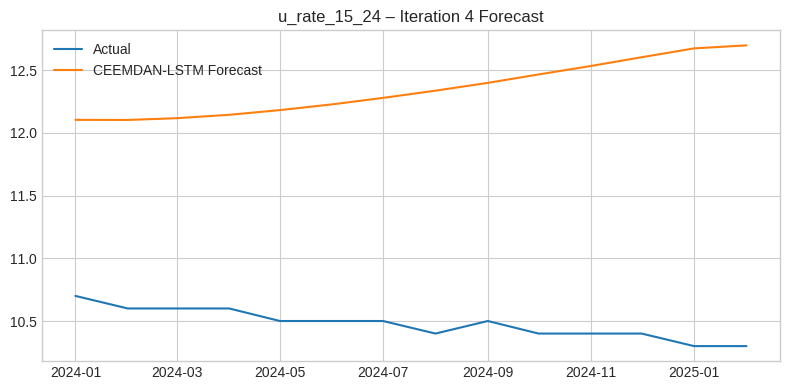



▶️  Target: u_rate_15_30
   Decomposed into 5 IMFs + residual


   ➡️  Combined MAE 2.346 | RMSE 2.495


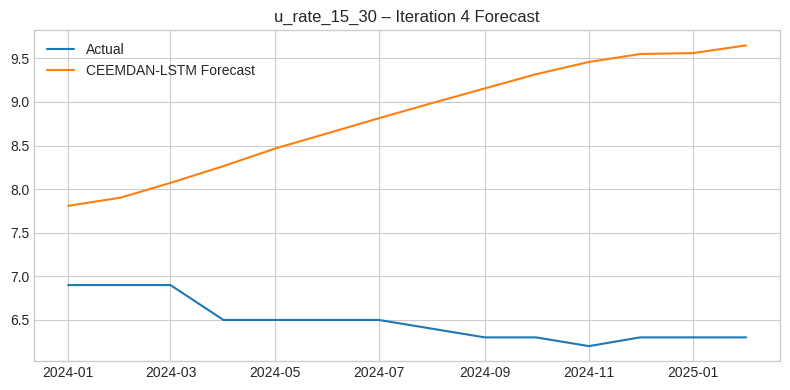


🎉  Iteration 4 complete.  Saved artefacts:
    lstm_i4_u_rate_15_24_imf1.h5 scaler_i4_u_rate_15_24_imf1.pkl
    lstm_i4_u_rate_15_24_imf2.h5 scaler_i4_u_rate_15_24_imf2.pkl
    lstm_i4_u_rate_15_24_imf3.h5 scaler_i4_u_rate_15_24_imf3.pkl
    lstm_i4_u_rate_15_24_imf4.h5 scaler_i4_u_rate_15_24_imf4.pkl
    lstm_i4_u_rate_15_24_imf5.h5 scaler_i4_u_rate_15_24_imf5.pkl
    lstm_i4_u_rate_15_30_imf1.h5 scaler_i4_u_rate_15_30_imf1.pkl
    lstm_i4_u_rate_15_30_imf2.h5 scaler_i4_u_rate_15_30_imf2.pkl
    lstm_i4_u_rate_15_30_imf3.h5 scaler_i4_u_rate_15_30_imf3.pkl
    lstm_i4_u_rate_15_30_imf4.h5 scaler_i4_u_rate_15_30_imf4.pkl
    lstm_i4_u_rate_15_30_imf5.h5 scaler_i4_u_rate_15_30_imf5.pkl
   metrics_i4.json


In [ ]:


import pandas as pd, numpy as np, matplotlib.pyplot as plt, json, math, random, os, warnings
warnings.filterwarnings("ignore")

from PyEMD import CEEMDAN
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

SEED = 42
tf.random.set_seed(SEED); np.random.seed(SEED); random.seed(SEED)
plt.style.use("seaborn-v0_8-whitegrid")

# loading data
URL_PARQUET = "https://storage.dosm.gov.my/labour/lfs_month_youth.parquet"
df = pd.read_parquet(URL_PARQUET)

df["date"] = pd.to_datetime(df["date"])
df = df.set_index("date").asfreq("MS")   # monthly (month-start)

print(" Data shape:", df.shape,
      "| Range:", df.index.min().date(), "→", df.index.max().date())

TARGETS = ["u_rate_15_24", "u_rate_15_30"]

#splits and defining key pipeline variables
TRAIN_END = "2021-12-31"
VAL_END   = "2023-12-31"
TEST_START = "2024-01-01"
HORIZON   = 14          # forecast months

N_LAG     = 12
EPOCHS    = 400
BATCH     = 8
PATIENCE  = 20          # EarlyStopping patience

def make_windows(arr, n_lag):
    X, y = [], []
    for i in range(n_lag, len(arr)):
        X.append(arr[i-n_lag:i])
        y.append(arr[i])
    return np.array(X), np.array(y)

metrics = {}

for target in TARGETS:
    print(f"\n\n  Target: {target}")

    # series splits
    series        = df[target]
    train_series  = series.loc[:TRAIN_END]
    val_series    = series.loc[TRAIN_END:].iloc[1:]
    val_series    = val_series.loc[:VAL_END]
    test_series   = series.loc[TEST_START:].iloc[:HORIZON]

    # CEEMDAN on train+val (no look-ahead to test)
    ceemdan = CEEMDAN()
    tv_array   = np.concatenate([train_series.values, val_series.values])
    imfs_tv    = ceemdan.ceemdan(tv_array, np.arange(len(tv_array)))
    n_imfs     = imfs_tv.shape[0]
    print(f"   Decomposed into {n_imfs} IMFs + residual")

    len_train = len(train_series)
    len_val   = len(val_series)

    forecast_sum = np.zeros(HORIZON)
    imf_records  = []

    # LOOP FOR EACH IMF
    for k in range(n_imfs):
        imf_tv = imfs_tv[k]                       # full train+val IMF
        imf_train = imf_tv[:len_train].reshape(-1,1)
        imf_val   = imf_tv[len_train:].reshape(-1,1)   # exactly len_val

        # scale (fit on train only)
        scaler = MinMaxScaler()
        train_scaled = scaler.fit_transform(imf_train)
        val_scaled   = scaler.transform(imf_val)

        # Created lagged training windows
        X_train, y_train = make_windows(train_scaled, N_LAG)
        X_val,   y_val   = make_windows(
            np.concatenate([train_scaled[-N_LAG:], val_scaled]), N_LAG
        )
        X_train = X_train.reshape((-1, N_LAG, 1))
        X_val   = X_val.reshape((-1, N_LAG, 1))

        # model architecture
        model = Sequential([
            LSTM(32, return_sequences=True, input_shape=(N_LAG,1)),
            Dropout(0.2),
            LSTM(32),
            Dropout(0.2),
            Dense(1)
        ])
        model.compile(optimizer="adam", loss="mse")
        es = EarlyStopping(monitor="val_loss", patience=PATIENCE,
                           restore_best_weights=True)
        model.fit(
            X_train, y_train,
            validation_data=(X_val, y_val),
            epochs=EPOCHS,
            batch_size=BATCH,
            verbose=0,
            callbacks=[es]
        )

        # recursive forecast on IMF
        hist = np.concatenate([train_scaled, val_scaled])[-N_LAG:].flatten().tolist()
        preds_sc = []
        for _ in range(HORIZON):
            x_in = np.array(hist[-N_LAG:]).reshape((1,N_LAG,1))
            yhat = model.predict(x_in, verbose=0)[0,0]
            preds_sc.append(yhat); hist.append(yhat)
        preds = scaler.inverse_transform(np.array(preds_sc).reshape(-1,1)).flatten()

        forecast_sum += preds

        # saveing  artefacts
        mfile = f"lstm_i4_{target}_imf{k+1}.h5"
        sfile = f"scaler_i4_{target}_imf{k+1}.pkl"
        model.save(mfile); pd.to_pickle(scaler, sfile)

        imf_records.append({"imf": k+1, "model": mfile, "scaler": sfile})

    # metrics and plots
    actual = test_series.values
    mae  = mean_absolute_error(actual, forecast_sum)
    rmse = math.sqrt(mean_squared_error(actual, forecast_sum))
    print(f"    Combined MAE {mae:.3f} | RMSE {rmse:.3f}")

    idx_test = test_series.index
    plt.figure(figsize=(8,4))
    plt.plot(idx_test, actual,        label="Actual")
    plt.plot(idx_test, forecast_sum,  label="CEEMDAN-LSTM Forecast")
    plt.title(f"{target} – Iteration 4 Forecast")
    plt.legend(); plt.tight_layout(); plt.show()

    metrics[target] = {
        "mae": mae,
        "rmse": rmse,
        "imfs": n_imfs,
        "components": imf_records
    }

# summary json
with open("metrics_i4.json", "w") as f:
    json.dump(metrics, f, indent=2)

print("\n  Iteration 4 complete.  Saved artefacts:")
for t in TARGETS:
    for comp in metrics[t]["components"]:
        print("   ", comp["model"], comp["scaler"])
print("   metrics_i4.json")


In [ ]:
#time to save both the models and the scaler into a wrapper
!pip install -q "tensorflow==2.15.1" scikit-learn PyEMD

import json, pickle, os, warnings
import numpy as np, pandas as pd
warnings.filterwarnings("ignore")

import tensorflow as tf
from PyEMD import CEEMDAN
from sklearn.preprocessing import MinMaxScaler

SEED = 42
tf.random.set_seed(SEED);  np.random.seed(SEED)

#defining wrpper class
class SingleLSTM:
    """Iteration 1 & 3 wrapper (one model, one scaler)."""
    def __init__(self, model_path, scaler_path,
                 n_lag=12, horizon=14):
        # compile=False → ignore loss/metrics aliases
        self.model   = tf.keras.models.load_model(model_path, compile=False)
        self.scaler  = pd.read_pickle(scaler_path)
        self.n_lag   = n_lag
        self.horizon = horizon

    def _forecast_scaled(self, scaled_hist):
        win = scaled_hist[-self.n_lag:].flatten().tolist()
        preds_sc = []
        for _ in range(self.horizon):
            x = np.array(win[-self.n_lag:]).reshape((1, self.n_lag, 1))
            yhat = self.model(x, training=False).numpy()[0, 0]
            preds_sc.append(yhat); win.append(yhat)
        return np.array(preds_sc).reshape(-1, 1)

    def predict(self, history):
        scaled = self.scaler.transform(history.reshape(-1, 1))
        preds_sc = self._forecast_scaled(scaled)
        return self.scaler.inverse_transform(preds_sc).flatten()


class CEEMDANEnsemble:
    """Iteration 2 & 4 wrapper (one LSTM per IMF)."""
    def __init__(self, comp_list, n_lag=12, horizon=14):
        self.n_lag   = n_lag
        self.horizon = horizon
        self.models  = [tf.keras.models.load_model(c["model"], compile=False)
                        for c in comp_list]
        self.scalers = [pd.read_pickle(c["scaler"])
                        for c in comp_list]

    def _forecast_imf(self, model, scaler, imf_series):
        scaled = scaler.transform(imf_series.reshape(-1,1))
        win = scaled[-self.n_lag:].flatten().tolist(); preds_sc=[]
        for _ in range(self.horizon):
            x = np.array(win[-self.n_lag:]).reshape((1, self.n_lag, 1))
            yhat = model(x, training=False).numpy()[0,0]
            preds_sc.append(yhat); win.append(yhat)
        return scaler.inverse_transform(
            np.array(preds_sc).reshape(-1,1)
        ).flatten()

    def predict(self, history):
        imfs = CEEMDAN().ceemdan(history, np.arange(len(history)))
        total = np.zeros(self.horizon)
        for k, (model, scaler) in enumerate(zip(self.models, self.scalers)):
            total += self._forecast_imf(model, scaler, imfs[k])
        return total


#Defining the save function
def load_meta(i):
    with open(f"metrics_i{i}.json") as f:
        return json.load(f)

targets    = ["u_rate_15_24", "u_rate_15_30"]
iterations = [1, 2, 3, 4]

for itr in iterations:
    meta = load_meta(itr)
    for tgt in targets:
        info = meta[tgt]

        if itr in (1, 3):
            w = SingleLSTM(info["model_file"], info["scaler_file"])
        else:
            w = CEEMDANEnsemble(info["components"])

        fname = f"wrapper_i{itr}_{tgt}.pkl"
        pickle.dump(w, open(fname, "wb"))
        print("  saved", fname)

print("\nExample use:")
print("import pickle, numpy as np")
print("w = pickle.load(open('wrapper_i4_u_rate_15_24.pkl','rb'))")
print("hist = np.array([...])     # past monthly rates")
print("forecast14 = w.predict(hist)")


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.3/475.3 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 666.6/666.6 kB 21.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 39.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 48.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 60.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 16.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 90.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.0/442.0 kB 25.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.4/78.4 kB 5.3 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-text 2.18.1 requires te

Loaded series: u_rate_15_24  points=111
Date range: 2016-01-01 → 2025-03-01

MAE  = 1.536
RMSE = 1.566


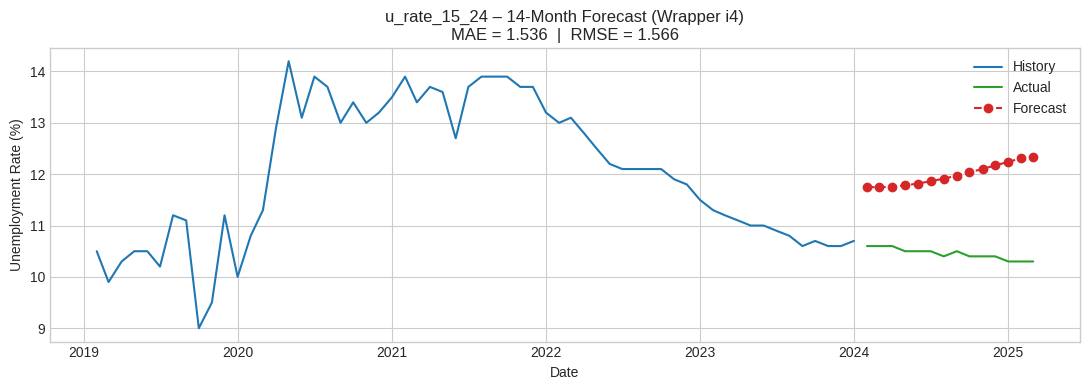

In [19]:
#Evaluate on the model by loading it
TARGET       = "u_rate_15_24"       # 'u_rate_15_24' or 'u_rate_15_30'
ITERATION    = 4                    # 1 | 2 | 3 | 4
WRAPPER_PATH = f"/content/wrapper_i{ITERATION}_{TARGET}.pkl"
FORECAST_H   = 14                   # must be ≤ 14 (wrapper horizon)


# Install wrapper dependencies
!pip install -q PyEMD scikit-learn

# Importing dependencies
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
import math, warnings; warnings.filterwarnings("ignore")

#Loading the Parquet dataset
url = "https://storage.dosm.gov.my/labour/lfs_month_youth.parquet"
df  = pd.read_parquet(url).set_index("date")

# Extract the desired series
series = df[TARGET]
print(f"Loaded series: {TARGET}  points={len(series)}")
print(f"Date range: {series.index.min()} → {series.index.max()}")

# Split into history and test
hist_values = series.values[:-FORECAST_H]
test_actual = series.values[-FORECAST_H:]
test_index  = series.index[-FORECAST_H:]

# Load the wrapper and produce a forecast
wrapper = pickle.load(open(WRAPPER_PATH, "rb"))
forecast = wrapper.predict(hist_values)[:FORECAST_H]

# Compute MAE & RMSE
mae  = mean_absolute_error(test_actual, forecast)
rmse = math.sqrt(mean_squared_error(test_actual, forecast))
print(f"\nMAE  = {mae:.3f}")
print(f"RMSE = {rmse:.3f}")

# Plot history, actual, and forecast
plt.figure(figsize=(11,4))

# 60 months of pre-test history
start_hist = max(0, len(series) - FORECAST_H - 60)
hist_dates = series.index[start_hist : len(series) - FORECAST_H]
hist_vals  = series.values[start_hist : len(series) - FORECAST_H]
plt.plot(hist_dates, hist_vals, label="History", color="#1f77b4")

# Actual final 14 months
plt.plot(test_index, test_actual, label="Actual", color="#2ca02c")

# Forecasting plot
plt.plot(test_index, forecast, "--o", label="Forecast", color="#d62728")

plt.title(f"{TARGET} – {FORECAST_H}-Month Forecast (Wrapper i{ITERATION})\n"
          f"MAE = {mae:.3f}  |  RMSE = {rmse:.3f}")
plt.ylabel("Unemployment Rate (%)")
plt.xlabel("Date")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


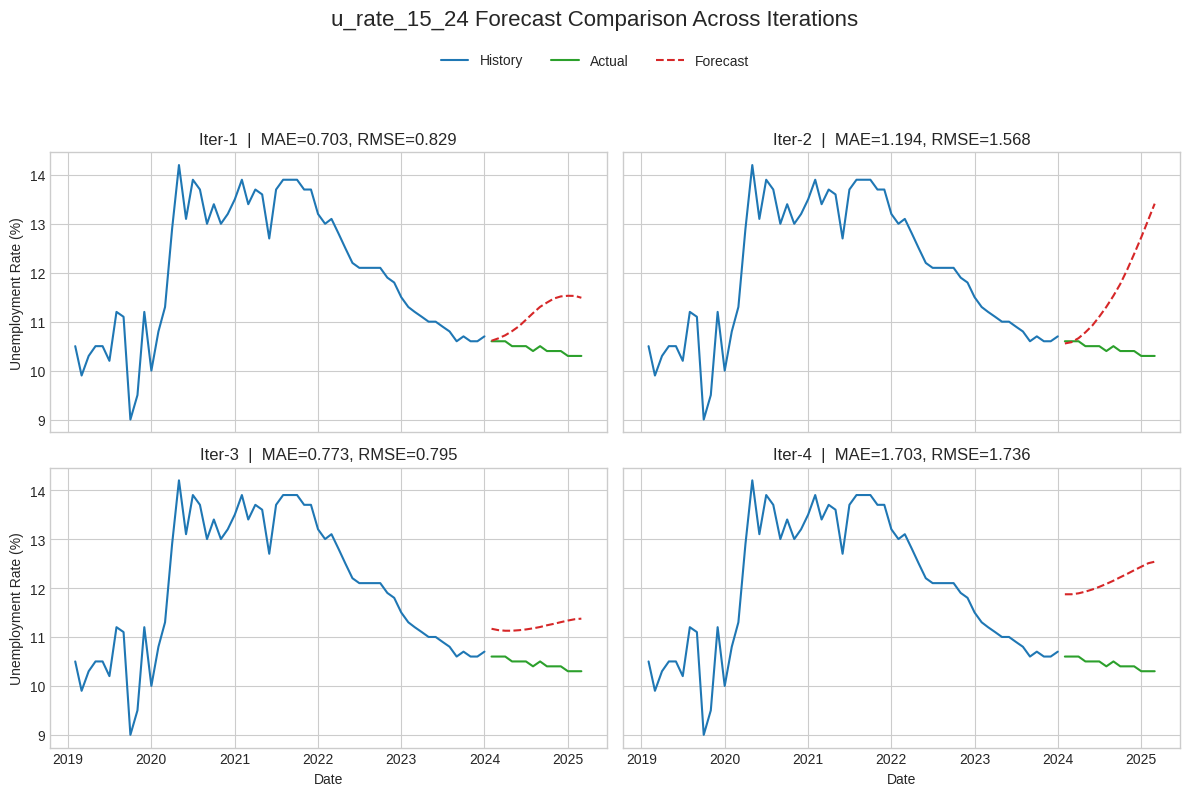

In [ ]:
TARGET      = "u_rate_15_24"       # 'u_rate_15_24' or 'u_rate_15_30'
FORECAST_H  = 14                   # ≤ 14 (wrapper horizon)


# Importing required dependencies
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
import math, warnings; warnings.filterwarnings("ignore")

# Load the Parquet dataset
url = "https://storage.dosm.gov.my/labour/lfs_month_youth.parquet"
df  = pd.read_parquet(url).set_index("date")
series = df[TARGET]

# Split into history and test 
hist_values = series.values[:-FORECAST_H]
test_actual = series.values[-FORECAST_H:]
test_index  = series.index[-FORECAST_H:]

#Create a 2×2 grid of subplots
fig, axs = plt.subplots(2, 2, figsize=(12, 8), sharex=True, sharey=True)
axs = axs.flatten()

# Loop through iterations 14
for idx, ITERATION in enumerate([1, 2, 3, 4]):
    WRAPPER_PATH = f"/content/wrapper_i{ITERATION}_{TARGET}.pkl"
    ax = axs[idx]

    try:
        wrapper = pickle.load(open(WRAPPER_PATH, "rb"))
    except FileNotFoundError:
        ax.text(
            0.5, 0.5,
            f"Wrapper i{ITERATION} not found",
            ha="center", va="center",
            fontsize=14, color="red"
        )
        ax.set_title(f"Iter-{ITERATION}: Missing")
        ax.set_xticks([]); ax.set_yticks([])
        continue

    # Forecast last 14 months
    forecast = wrapper.predict(hist_values)[:FORECAST_H]

    # Compute the metrics
    mae  = mean_absolute_error(test_actual, forecast)
    rmse = math.sqrt(mean_squared_error(test_actual, forecast))

    # Plot 60 months of pre-test history
    start_hist = max(0, len(series) - FORECAST_H - 60)
    hist_dates = series.index[start_hist : len(series) - FORECAST_H]
    hist_vals  = series.values[start_hist : len(series) - FORECAST_H]
    ax.plot(hist_dates, hist_vals, label="History", color="#1f77b4")

    # Plot actual final 14 months
    ax.plot(test_index, test_actual, label="Actual", color="#2ca02c")

    # Plot forecast as dashed line
    ax.plot(test_index, forecast, "--", label="Forecast", color="#d62728")

    ax.set_title(f"Iter-{ITERATION}  |  MAE={mae:.3f}, RMSE={rmse:.3f}")
    ax.grid(True)
    if idx % 2 == 0:
        ax.set_ylabel("Unemployment Rate (%)")
    if idx >= 2:
        ax.set_xlabel("Date")

# Adjust top padding and add shared legends
fig.subplots_adjust(top=0.88)  # extra space for title/legend

handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, loc="upper center", ncol=3, bbox_to_anchor=(0.5, 0.95))

plt.suptitle(
    f"Unemployment rate for the group of 15 to 24 years old Forecast Comparison Across Iterations",
    fontsize=16,
    y=0.99,
)
plt.tight_layout(rect=[0, 0, 1, 0.90])

plt.show()


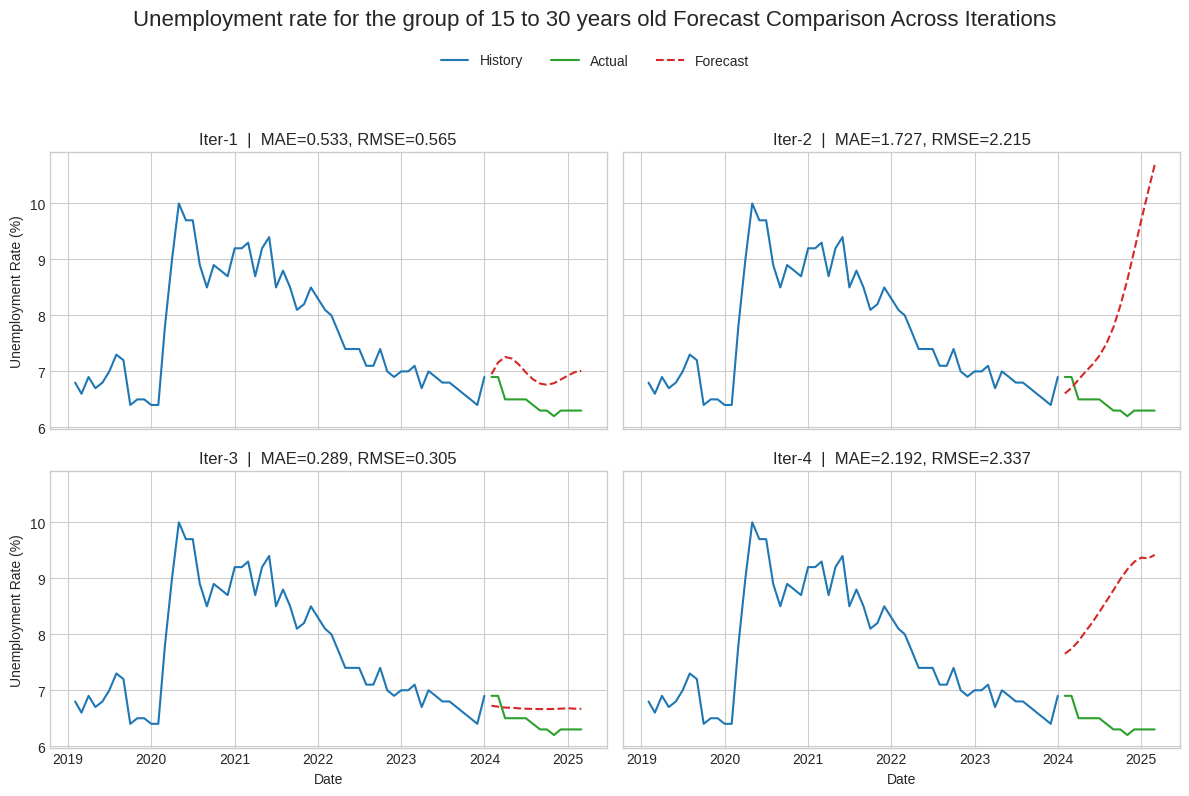

In [ ]:

TARGET      = "u_rate_15_30"
FORECAST_H  = 14

#Imports
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
import math, warnings; warnings.filterwarnings("ignore")

# Load the Parquet dataset
url = "https://storage.dosm.gov.my/labour/lfs_month_youth.parquet"
df  = pd.read_parquet(url).set_index("date")
series = df[TARGET]

#Split into history and test (last 14 months)
hist_values = series.values[:-FORECAST_H]
test_actual = series.values[-FORECAST_H:]
test_index  = series.index[-FORECAST_H:]

# Created a 2×2 grid of subplots
fig, axs = plt.subplots(2, 2, figsize=(12, 8), sharex=True, sharey=True)
axs = axs.flatten()

# Looping through iterations 1→4
for idx, ITERATION in enumerate([1, 2, 3, 4]):
    WRAPPER_PATH = f"/content/wrapper_i{ITERATION}_{TARGET}.pkl"
    ax = axs[idx]

    try:
        wrapper = pickle.load(open(WRAPPER_PATH, "rb"))
    except FileNotFoundError:
        ax.text(
            0.5, 0.5,
            f"Wrapper i{ITERATION} not found",
            ha="center", va="center",
            fontsize=14, color="red"
        )
        ax.set_title(f"Iter-{ITERATION}: Missing")
        ax.set_xticks([]); ax.set_yticks([])
        continue

    # Forecast on 14 months
    forecast = wrapper.predict(hist_values)[:FORECAST_H]

    # Compute metrics
    mae  = mean_absolute_error(test_actual, forecast)
    rmse = math.sqrt(mean_squared_error(test_actual, forecast))

    # Plot 60 months of pre-test history
    start_hist = max(0, len(series) - FORECAST_H - 60)
    hist_dates = series.index[start_hist : len(series) - FORECAST_H]
    hist_vals  = series.values[start_hist : len(series) - FORECAST_H]
    ax.plot(hist_dates, hist_vals, label="History", color="#1f77b4")

    # Plot actual final 14 months
    ax.plot(test_index, test_actual, label="Actual", color="#2ca02c")

    # Plot forecast line
    ax.plot(test_index, forecast, "--", label="Forecast", color="#d62728")

    ax.set_title(f"Iter-{ITERATION}  |  MAE={mae:.3f}, RMSE={rmse:.3f}")
    ax.grid(True)
    if idx % 2 == 0:
        ax.set_ylabel("Unemployment Rate (%)")
    if idx >= 2:
        ax.set_xlabel("Date")

fig.subplots_adjust(top=0.88)

handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, loc="upper center", ncol=3, bbox_to_anchor=(0.5, 0.95))

plt.suptitle(
    f"Unemployment rate for the group of 15 to 30 years old Forecast Comparison Across Iterations",
    fontsize=16,
    y=0.99,
)
plt.tight_layout(rect=[0, 0, 1, 0.90])
plt.show()
